![STScI Logo](../../../_static/stsci_header.png)

<a id="titleFocus"></a>
# Focus Diverse ePSFs for ACS/WFC

This notebook highlights how to use the focus_diverse_psfs module within acstools to retrieve empirical, focus-diverse ePSFs for ACS/WFC data. Please see the [webtool](https://acspsf.stsci.edu/), [ACS ISR 2018-08](https://ui.adsabs.harvard.edu/abs/2018acs..rept....8B/abstract), and [ACS ISR 2023-06](https://ui.adsabs.harvard.edu/abs/2023acs..rept....6A/abstract) for more details.

## Table of Contents

[1. Imports](#imports) <br>
[2. Downloading and Examining a Single Focus-Diverse ePSF file](#download) <br>
[3. Batch Downloads](#batch) <br>
- [A. via an Input Text File](#text)
- [B. via *astroquery*](#astroquery) <br>

[4. Further Spatial Interpolations](#spatial) <br>
[About this Notebook](#about)

<a id="imports"></a>
## 1. Imports

In [1]:
import os

from astropy.io import fits
from astroquery.mast import Observations

import ipywidgets as widgets
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import the focus_diverse_psfs functions from acstools
from acstools.focus_diverse_epsfs import psf_retriever, multi_psf_retriever, interp_epsf

/home/runner/micromamba/envs/ci-env/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:24: UserWarning: skimage not installed. MRT calculation will not work: ModuleNotFoundError("No module named 'skimage'")
  warnings.warn(f'skimage not installed. MRT calculation will not work: {repr(e)}')  # noqa


<a id="download"></a>
## 2. Downloading and Examining a Single Focus-Diverse ePSF file

Let's begin with downloading the focus-diverse ePSF FITS file that matches a single observation of our choosing. For this example, we will aim to retrieve the ePSF file for the observation rootname "jds408jsq", from GO-15445 (PI W. Keel).

Please note that only IPPPSSOOT formats will work (e.g. jds408jsq), and the tool does not support inputs in the form of association IDs or product names (e.g. jds408010 or jds408011).


Make sure to change the variable "download_location" to an existing folder on your local machine. 

In [2]:
%%time 

# example of a single retrieval


# Set the download location to the current working directory
download_location = os.path.join(os.getcwd(), 'downloads')
os.makedirs(download_location, exist_ok=True)

# call the psf_retriever function with observation rootname
retrieved_download = psf_retriever('jds408jsq', download_location) 

CPU times: user 37.7 ms, sys: 5.08 ms, total: 42.8 ms
Wall time: 1.06 s


<hr>


The direct return of the psf_retriever function is the retrieved file name. The name has the format %ROOTNAME-STDPBF_ACSWFC_%FILTER_%SM_%F.fits, where the variables are:

%ROOTNAME- this is the image rootname that you passed to psf_retriever, which is appended to allow for easier bookkeeping of retrieved files

%FILTER- this is the ACS/WFC filter that was used in the observation

%SM- Short for "Servicing Mission", SM3 or SM4, depending on when the observation was taken.

%F- Best fit focus group that the individual exposures lies within.

<hr>


We can now examine the retrieved FITS file.

In [3]:
# give path to downloaded file
retrieved_filepath = os.path.abspath(retrieved_download)

if not os.path.isfile(retrieved_filepath):
    raise FileNotFoundError(f"Expected file not found at {retrieved_filepath}")

# open the file with astropy.io
with fits.open(retrieved_filepath) as hdu:
    hdu.info()  # Display basic information about the file

Filename: /home/runner/work/hst_notebooks/hst_notebooks/notebooks/ACS/acs_focus_diverse_epsfs/downloads/jds408jsq-STDPBF_ACSWFC_F606W_SM4_F11.2.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      35   (101, 101, 90)   float32   


With the output above, we can see that the dimensions of the file are 101 x 101 x 90. This corresponds to a total of 90 ePSFs, each one with x,y dimensions of 101 x 101. The 90 ePSFs span the range of the two WFC chips and correspond to a 9 x 10 spatial grid (see Figure 1 in [ACS ISR 2018-08](https://ui.adsabs.harvard.edu/abs/2018acs..rept....8B/abstract)). 

We show these ePSFs below in a widget which allows you to quickly scroll through and get a sense of the spatial differences. 

In [4]:
# # First, lets grab the image data from the retrieved FITS file
ePSFs = fits.getdata(retrieved_filepath, ext=0)


def show_ePSF(grid_index):
    plt.imshow(ePSFs[grid_index], cmap='viridis',
               norm=colors.LogNorm(vmin=1e-4), origin='lower')
    cbar = plt.colorbar()
    cbar.set_label('Fractional Energy')


widgets.interact(show_ePSF, grid_index=(0, 89, 1))

interactive(children=(IntSlider(value=44, description='grid_index', max=89), Output()), _dom_classes=('widget-…

<function __main__.show_ePSF(grid_index)>

<a id="batch"></a>
## 3. Batch Downloads

Here we show how to perform batch downloads for a large set of input rootnames, via two separate methods.

<hr>


<a id="text"></a>
### A. via an Input Text File

With an input text file of one rootname per line, we can use the multi_psf_retriever function with the "fromTextFile" parameter set to True to batch download the desired focus-diverse ePSFs.

In [5]:
# specify the name of the input text file (with one rootname per line),
# as well as the desired download location for our focus-diverse ePSFs

input_list = 'input_ipsoots.txt'

In [6]:
%%time 

# use the multi_psf_retriever function to retrieve our ePSFs
retrieved_downloads = multi_psf_retriever(input_list, download_location)

print('# of matching files: ', len(retrieved_downloads))

[                                        ] | 0% Completed | 158.46 us

[                                        ] | 0% Completed | 101.44 ms

[                                        ] | 0% Completed | 206.80 ms

[                                        ] | 0% Completed | 309.50 ms

[                                        ] | 0% Completed | 410.42 ms

[                                        ] | 0% Completed | 511.30 ms

[                                        ] | 0% Completed | 612.16 ms

[                                        ] | 0% Completed | 713.01 ms

[                                        ] | 0% Completed | 813.95 ms

[                                        ] | 0% Completed | 914.80 ms

[                                        ] | 0% Completed | 1.02 s

[                                        ] | 0% Completed | 1.12 s

/home/runner/micromamba/envs/ci-env/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:24: UserWarning: skimage not installed. MRT calculation will not work: ModuleNotFoundError("No module named 'skimage'")
  warnings.warn(f'skimage not installed. MRT calculation will not work: {repr(e)}')  # noqa
/home/runner/micromamba/envs/ci-env/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:24: UserWarning: skimage not installed. MRT calculation will not work: ModuleNotFoundError("No module named 'skimage'")
  warnings.warn(f'skimage not installed. MRT calculation will not work: {repr(e)}')  # noqa


[                                        ] | 0% Completed | 1.22 s

[                                        ] | 0% Completed | 1.32 s

[                                        ] | 0% Completed | 1.42 s

[                                        ] | 0% Completed | 1.52 s

[                                        ] | 0% Completed | 1.62 s

[                                        ] | 0% Completed | 1.72 s

[                                        ] | 0% Completed | 1.82 s

[                                        ] | 0% Completed | 1.92 s

[                                        ] | 0% Completed | 2.03 s

[                                        ] | 0% Completed | 2.13 s

[                                        ] | 0% Completed | 2.23 s

[                                        ] | 0% Completed | 2.33 s

[                                        ] | 0% Completed | 2.43 s

[                                        ] | 0% Completed | 2.53 s

[                                        ] | 0% Completed | 2.63 s

[                                        ] | 0% Completed | 2.73 s

[                                        ] | 0% Completed | 2.83 s

[                                        ] | 0% Completed | 2.93 s

[                                        ] | 0% Completed | 3.03 s

[                                        ] | 0% Completed | 3.13 s

[                                        ] | 0% Completed | 3.23 s

[                                        ] | 0% Completed | 3.33 s

[                                        ] | 0% Completed | 3.43 s

[                                        ] | 0% Completed | 3.54 s

[                                        ] | 0% Completed | 3.64 s

[                                        ] | 0% Completed | 3.74 s

[                                        ] | 0% Completed | 3.84 s

[                                        ] | 0% Completed | 3.94 s

[                                        ] | 0% Completed | 4.04 s

[                                        ] | 0% Completed | 4.14 s

[                                        ] | 0% Completed | 4.24 s

[                                        ] | 0% Completed | 4.34 s

[                                        ] | 0% Completed | 4.44 s

[                                        ] | 0% Completed | 4.54 s

[                                        ] | 0% Completed | 4.64 s

[                                        ] | 0% Completed | 4.74 s

[                                        ] | 0% Completed | 4.84 s

[                                        ] | 0% Completed | 4.94 s

[                                        ] | 0% Completed | 5.05 s

[                                        ] | 0% Completed | 5.15 s

[                                        ] | 0% Completed | 5.25 s

[################                        ] | 40% Completed | 5.35 s

[################                        ] | 40% Completed | 5.45 s

[################                        ] | 40% Completed | 5.55 s

[################                        ] | 40% Completed | 5.65 s

[################                        ] | 40% Completed | 5.75 s

[################                        ] | 40% Completed | 5.85 s

[################                        ] | 40% Completed | 5.95 s

[################                        ] | 40% Completed | 6.05 s

[################                        ] | 40% Completed | 6.15 s

[################                        ] | 40% Completed | 6.25 s

[################                        ] | 40% Completed | 6.35 s

[################                        ] | 40% Completed | 6.45 s

[################                        ] | 40% Completed | 6.56 s

[################                        ] | 40% Completed | 6.66 s

[################                        ] | 40% Completed | 6.76 s

[################                        ] | 40% Completed | 6.86 s

[################                        ] | 40% Completed | 6.96 s

[################                        ] | 40% Completed | 7.06 s

[################                        ] | 40% Completed | 7.16 s

[################                        ] | 40% Completed | 7.26 s

[################                        ] | 40% Completed | 7.36 s

[################                        ] | 40% Completed | 7.46 s

[########################################] | 100% Completed | 7.56 s

# of matching files:  10
CPU times: user 110 ms, sys: 25.4 ms, total: 136 ms
Wall time: 7.82 s


<hr>


<a id="astroquery"></a>
### B. via *astroquery*

Alternatively, we can use *astroquery* to simply grab the rootnames for all ACS/WFC images within a given HST proposal and retrieve the corresponding focus-diverse ePSFs. 

Here we provide an example of using astroquery and the multi_psf_retriever function to grab all matching focus-diverse ePSFs for observations of the Leo P galaxy from GO-13376 (PI K. McQuinn).

In [7]:
# # use astroquery to grab ACS/WFC observations from GO-13376 (PI K. McQuinn)
obsTable = Observations.query_criteria(obs_collection='HST', proposal_id="13376",
                                       instrument_name="ACS/WFC", provenance_name="CALACS")

# retrieve the data products for the above observations
dataProducts = Observations.get_product_list(obsTable)

# filter the data products for just the FLC files from HST, and not the Hubble Advanced Products (HAP) project
dataProducts = dataProducts[(dataProducts['productSubGroupDescription'] == 'FLC') &
                            (dataProducts['type'] == 'S')]

# create a list of corresponding rootnames
obs_rootnames = list(dataProducts['obs_id'])

In [8]:
%%time

# use the multi_psf_retriever function to retrieve our ePSFs 
retrieved_downloads = multi_psf_retriever(obs_rootnames, download_location)

print('# of matching files: ', len(retrieved_downloads))

[                                        ] | 0% Completed | 106.78 us

[                                        ] | 0% Completed | 101.12 ms

[                                        ] | 0% Completed | 203.84 ms

[                                        ] | 0% Completed | 308.77 ms

[                                        ] | 0% Completed | 409.52 ms

[                                        ] | 0% Completed | 510.40 ms

[                                        ] | 0% Completed | 614.33 ms

[                                        ] | 0% Completed | 715.22 ms

[                                        ] | 0% Completed | 818.49 ms

[                                        ] | 0% Completed | 920.76 ms

[                                        ] | 0% Completed | 1.02 s

[                                        ] | 0% Completed | 1.12 s

[                                        ] | 0% Completed | 1.22 s

[                                        ] | 0% Completed | 1.33 s

[                                        ] | 0% Completed | 1.43 s

[                                        ] | 0% Completed | 1.53 s

[                                        ] | 0% Completed | 1.63 s

[                                        ] | 0% Completed | 1.73 s

[                                        ] | 0% Completed | 1.84 s

[                                        ] | 0% Completed | 1.94 s

[                                        ] | 0% Completed | 2.04 s

[                                        ] | 0% Completed | 2.14 s

/home/runner/micromamba/envs/ci-env/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:24: UserWarning: skimage not installed. MRT calculation will not work: ModuleNotFoundError("No module named 'skimage'")
  warnings.warn(f'skimage not installed. MRT calculation will not work: {repr(e)}')  # noqa
/home/runner/micromamba/envs/ci-env/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:24: UserWarning: skimage not installed. MRT calculation will not work: ModuleNotFoundError("No module named 'skimage'")
  warnings.warn(f'skimage not installed. MRT calculation will not work: {repr(e)}')  # noqa
/home/runner/micromamba/envs/ci-env/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:24: UserWarning: skimage not installed. MRT calculation will not work: ModuleNotFoundError("No module named 'skimage'")
  warnings.warn(f'skimage not installed. MRT calculation will not work: {repr(e)}')  # noqa


[                                        ] | 0% Completed | 2.25 s

[                                        ] | 0% Completed | 2.35 s

/home/runner/micromamba/envs/ci-env/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:24: UserWarning: skimage not installed. MRT calculation will not work: ModuleNotFoundError("No module named 'skimage'")
  warnings.warn(f'skimage not installed. MRT calculation will not work: {repr(e)}')  # noqa
/home/runner/micromamba/envs/ci-env/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:24: UserWarning: skimage not installed. MRT calculation will not work: ModuleNotFoundError("No module named 'skimage'")
  warnings.warn(f'skimage not installed. MRT calculation will not work: {repr(e)}')  # noqa


[                                        ] | 0% Completed | 2.45 s

[                                        ] | 0% Completed | 2.55 s

[                                        ] | 0% Completed | 2.66 s

/home/runner/micromamba/envs/ci-env/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:24: UserWarning: skimage not installed. MRT calculation will not work: ModuleNotFoundError("No module named 'skimage'")
  warnings.warn(f'skimage not installed. MRT calculation will not work: {repr(e)}')  # noqa


[                                        ] | 0% Completed | 2.76 s

[                                        ] | 0% Completed | 2.86 s

[                                        ] | 0% Completed | 2.96 s

[                                        ] | 0% Completed | 3.06 s

[                                        ] | 0% Completed | 3.16 s

[                                        ] | 0% Completed | 3.26 s

[                                        ] | 0% Completed | 3.36 s

[                                        ] | 0% Completed | 3.46 s

[                                        ] | 0% Completed | 3.56 s

[                                        ] | 0% Completed | 3.66 s

[                                        ] | 0% Completed | 3.76 s

[                                        ] | 0% Completed | 3.86 s

[                                        ] | 0% Completed | 3.96 s

[                                        ] | 0% Completed | 4.07 s

[                                        ] | 0% Completed | 4.17 s

[                                        ] | 0% Completed | 4.27 s

[                                        ] | 0% Completed | 4.37 s

[                                        ] | 0% Completed | 4.47 s

[                                        ] | 0% Completed | 4.57 s

[                                        ] | 0% Completed | 4.67 s

[                                        ] | 0% Completed | 4.77 s

[                                        ] | 0% Completed | 4.87 s

[                                        ] | 0% Completed | 4.97 s

[                                        ] | 0% Completed | 5.07 s

[                                        ] | 0% Completed | 5.17 s

[                                        ] | 0% Completed | 5.27 s

[                                        ] | 0% Completed | 5.37 s

[                                        ] | 0% Completed | 5.47 s

[                                        ] | 0% Completed | 5.57 s

[                                        ] | 0% Completed | 5.68 s

[                                        ] | 0% Completed | 5.78 s

[                                        ] | 0% Completed | 5.88 s

[                                        ] | 0% Completed | 5.98 s

[                                        ] | 0% Completed | 6.08 s

[                                        ] | 0% Completed | 6.18 s

[                                        ] | 0% Completed | 6.28 s

[                                        ] | 0% Completed | 6.38 s

[                                        ] | 0% Completed | 6.48 s

[                                        ] | 0% Completed | 6.58 s

[                                        ] | 0% Completed | 6.68 s

[####                                    ] | 11% Completed | 6.78 s

[####                                    ] | 11% Completed | 6.88 s

[####                                    ] | 11% Completed | 6.98 s

[####                                    ] | 11% Completed | 7.08 s

[####                                    ] | 11% Completed | 7.19 s

[####                                    ] | 11% Completed | 7.29 s

[####                                    ] | 11% Completed | 7.39 s

[####                                    ] | 11% Completed | 7.49 s

[####                                    ] | 11% Completed | 7.59 s

[####                                    ] | 11% Completed | 7.69 s

[####                                    ] | 11% Completed | 7.79 s

[####                                    ] | 11% Completed | 7.89 s

[####                                    ] | 11% Completed | 7.99 s

[####                                    ] | 11% Completed | 8.09 s

[####                                    ] | 11% Completed | 8.19 s

[####                                    ] | 11% Completed | 8.29 s

[####                                    ] | 11% Completed | 8.39 s

[####                                    ] | 11% Completed | 8.49 s

[###########                             ] | 29% Completed | 8.59 s

[##################                      ] | 47% Completed | 8.69 s

[##################                      ] | 47% Completed | 8.80 s

[################################        ] | 82% Completed | 8.90 s

[########################################] | 100% Completed | 9.00 s

# of matching files:  34
CPU times: user 92.5 ms, sys: 20.1 ms, total: 113 ms
Wall time: 9.49 s


<a id="spatial"></a>
## 4. Further Spatial Interpolations

Users may be interested in further interpolating the provided ePSF array to any arbitrary (x,y) coordinate. The function interp_epsf() allows us to retrieve this (using bi-linear interpolation).

For example, we can retrieve the ePSF loaded from its FITS file above and interpolate to x,y = (2000,2000) on WFC1, which is near the middle of the detector along the x-axis, and near the top of the WFC1 chip (and the detector overall). 

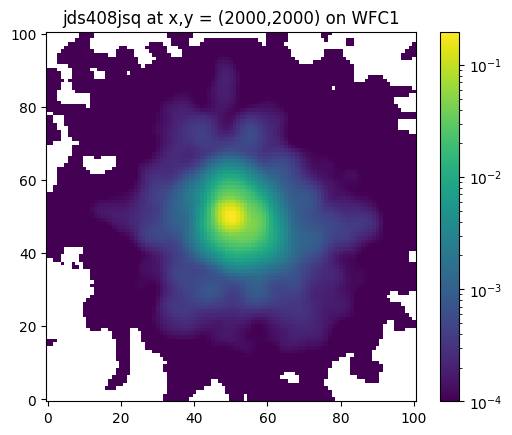

In [9]:
x = 2000
y = 2000
chip = "WFC1"

# get interpolated ePSF in supersampled space
P = interp_epsf(ePSFs, x, y, chip)
plt.imshow(P, cmap='viridis', norm=colors.LogNorm(vmin=1e-4), origin='lower')
plt.title('jds408jsq at x,y = (2000,2000) on WFC1')
plt.colorbar()

By default, the ePSFs come with 4x supersampling. We can output them in detector space by setting the "pixel_space" = True.

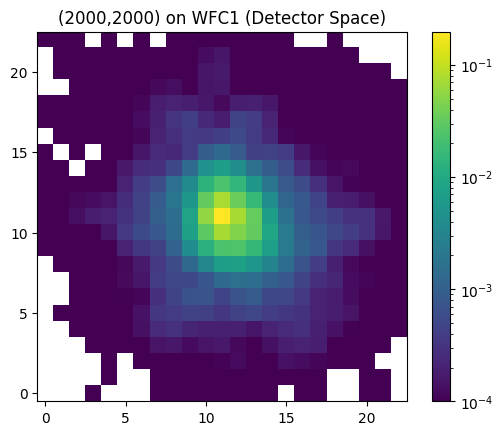

In [10]:
# get interpolated ePSF in detector space
P = interp_epsf(ePSFs, x, y, chip,
                pixel_space=True)
plt.imshow(P, cmap='viridis', norm=colors.LogNorm(vmin=1e-4), origin='lower')
plt.title('(2000,2000) on WFC1 (Detector Space)')
plt.colorbar()

Lastly, we can shift the ePSF to any sub-pixel phase by specifying the individual x and y subpixel offsets. The code uses bi-cubic interpolation to perform these sub-pixel phase shifts. 

Note that pixel_space must be set to True to use these subpixel offsets. Also note that the code only supports this bi-cubic interpolation to the second decimal place (e.g. subpixel_x = 0.77 and subpixel_y = 0.33)

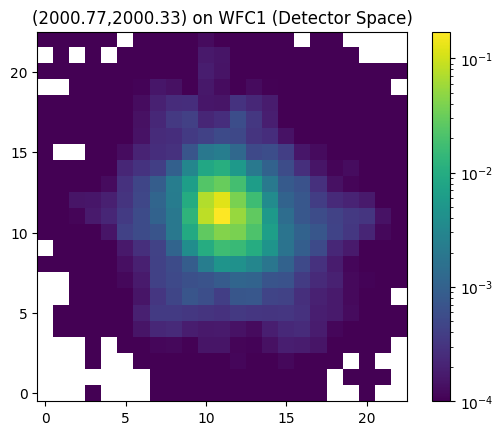

In [11]:
# # get interpolated ePSF in detector space with specified sub-pixel shifts
P = interp_epsf(ePSFs, x, y, chip,
                pixel_space=True,
                subpixel_x=0.77, subpixel_y=0.33)

plt.imshow(P, cmap='viridis', norm=colors.LogNorm(vmin=1e-4), origin='lower')
plt.title('(2000.77,2000.33) on WFC1 (Detector Space)')
plt.colorbar()

<a id="about"></a>
## About this Notebook
**Curator:** Gagandeep Anand, ACS Instrument Team, Space Telescope Science Institute <br>

### For more help:

More details may be found on the [ACS website](http://www.stsci.edu/hst/instrumentation/acs) and in the [ACS Instrument](https://hst-docs.stsci.edu/display/ACSIHB) and [Data Handbooks](https://hst-docs.stsci.edu/acsdhb).

Please visit the [HST Help Desk](http://hsthelp.stsci.edu). Through the help desk portal, you can explore the HST Knowledge Base and request additional help from experts.

<hr>

[Top of Page](#titleFocus)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/hst_notebooks/main/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 